In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import sqlite3

from datetime import datetime
from collections import Counter

from sklearn.preprocessing import StandardScaler
from nltk import ngrams as make_ngrams
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

sys.path.insert(1, "C:/Users/Eddie/Documents/language_change_methods")
import vnc
from utility_functions import tokenise

In [2]:
sql_get_all_posts ="""
SELECT c.uid, m.name, m.PimsId, p.party, d.date, c.body, c.topic, c.section, s.tmay_deal, s.benn_act, s.ref_stance, s.constituency_leave, c.usas_file
FROM contributions as c
INNER JOIN members as m
ON m.PimsId = c.member
INNER JOIN debates as d
ON d.uid = c.debate
INNER JOIN member_party as p
ON p.PimsId = m.PimsId
INNER JOIN member_stances as s
ON s.PimsId = m.PimsId
WHERE (d.date BETWEEN date("2015-05-01") AND date("2019-12-11"))
AND (((d.date BETWEEN p.start AND p.end) AND NOT (p.end IS NULL))
OR ((d.date >= p.start) AND (p.end IS NULL)));""".strip()

In [3]:
DB_FP = "C:/Users/Eddie/Documents/Datasets/commons.db"
hansard_dir = "C:/Users/Eddie/Documents/hansard-stuff"
out_dir = "C:/Users/Eddie/Documents/Datasets/Hansard Output/Thesis_Graphs"

sys.path.insert(1, "./pipeline")
from build_features import split_corpus

In [4]:
with open(hansard_dir + "/speakers.json") as speaker_file:
    speaker_list = json.load(speaker_file)

In [5]:
%%time
conn = sqlite3.connect(DB_FP)
curs = conn.cursor()

# Gets all the contributions and creates a nice dataframe
all_contributions = pd.read_sql_query(sql_get_all_posts, conn)
all_contributions.columns = ['uid', 'name', 'PimsId', 'party', 'date', 'text', 'topic', 'section', 'tmay_deal', 'benn_act', 'ref_stance', 'constituency_leave', 'usas_file']
all_contributions.set_index("uid", inplace=True)
convert_to_date = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
all_contributions['date'] = all_contributions['date'].apply(convert_to_date)

all_contributions = all_contributions.query("PimsId not in @speaker_list")
all_contributions.sort_values("date", inplace=True)

# Tokenise the contributions
all_toks =  all_contributions["text"].apply(tokenise)

# Get the EU and Non-EU mentions
eu_mentions, non_eu_mentions = split_corpus(all_contributions, "eu")

Wall time: 3min 11s


In [6]:
from features import get_wordcounts_multiple_texts, make_feature_matrix, function_words, get_top_n_toks

In [7]:
from utility_functions import get_data_windows

In [8]:
%%time
all_counts = get_wordcounts_multiple_texts(all_toks)

Wall time: 4.53 s


In [9]:
%%time
win_counts = dict()
n_words_per_window = dict()
for window, contribs in get_data_windows(eu_mentions, 5000, 5000, time_column="date"):
    win_counts[window] = get_wordcounts_multiple_texts(all_toks.loc[contribs.index])
    n_words_per_window[window] = sum(win_counts[window].values())
    
win_counts = {i: {tok: count for tok, count in post.items() if tok not in function_words} for i, post in win_counts.items()}
top_n = get_top_n_toks(win_counts.values(), 1000)
win_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in win_counts.items()}
# win_counts = pd.Series(win_counts)

feats, feat_names = make_feature_matrix(win_counts, False)
norm_feats = feats / np.array(list(n_words_per_window.values()))[:,None]

Wall time: 3.46 s


In [10]:
def create_bow_feat_table(contributions, tokens, group_indexes, win_size, win_step, n_toks, w_list=None, norm=True):
    win_counts = {gname: dict() for gname in group_indexes}
    n_words_per_window = {gname: dict() for gname in group_indexes}
    for window, contribs in get_data_windows(contributions, win_size, win_step, time_column="date"):
        for gname in group_indexes:
            g_contribs = contribs.loc[contribs.index.isin(group_indexes[gname])]
            curr_counts = get_wordcounts_multiple_texts(tokens.loc[g_contribs.index])
            curr_counts = {tok: count for tok, count in curr_counts.items() if tok not in function_words}
            
            win_counts[gname][window] = curr_counts
            n_words_per_window[gname][window] = sum(win_counts[gname][window].values())
            
    
    if n_toks is not None:
        # Get the top n tokens
        top_n = get_top_n_toks(tokens.loc[contributions.index], n_toks)
    elif w_list is not None:
        # If using a word list instead, set this here.
        top_n = w_list
    else:
        top_n = None

    out_dic = dict()
    for gname in group_indexes:
        # Get the current group's counts
        curr_win_counts = win_counts[gname]
        if top_n is not None:
            # Filter down to only the top n words
            curr_win_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in curr_win_counts.items()}

        # Create the feature matrix
        feats, feat_names = make_feature_matrix(curr_win_counts, False)
        # Normalise the counts
        if norm:
            feats = feats / np.array(list(n_words_per_window[gname].values()))[:,None]
            
        feats = pd.DataFrame(feats, index=list(curr_win_counts), columns=feat_names)
        
        if not norm:
            feats["TOTAL"] = list(n_words_per_window[gname].values())
            
        # Make a nice dataframe
        out_dic[gname] = feats
    return out_dic

In [11]:
from vnc import VNC, plot_horizontal_vnc

In [12]:
# This method calculates cosine distance between two vectors.
from scipy.spatial.distance import cosine as cosine_dist
# This method simply inverts it to get similarity.
cosine_sim = lambda x,y: 1 - cosine_dist(x,y)

In [13]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

def coph_coeff(curr_vnc, feat_matrix):
    c, coph_dists = cophenet(curr_vnc.d_list, pdist(feat_matrix))
    return c

In [14]:
def create_vnc(curr_contributions, all_toks, gnames, g1, g2, win_size, win_step, n_toks, w_list=None):
    g_feats = create_bow_feat_table(curr_contributions, all_toks, 
                                    {gnames[0]: g1.index, gnames[1]: g2.index}, 
                                    win_size=win_size, win_step=win_step, n_toks=n_toks, w_list=w_list)

    vnc1 = VNC(g_feats[gnames[0]], cosine_sim)
    vnc2 = VNC(g_feats[gnames[1]], cosine_sim)
    return vnc1, vnc2, g_feats

In [71]:
def vnc_comparison(gnames, vnc1, vnc2, colours):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(100, 40), sharey=True)
    plot_horizontal_vnc(vnc1, ax1, "left", colours[0], gnames[0], None)
    plot_horizontal_vnc(vnc2, ax2, "right", colours[1], gnames[1], None)

    for ytick in ax2.yaxis.get_ticklabels():
        ytick.set_size(0)
        
    if ax1.get_xlim()[0] > ax2.get_xlim()[1]:
        ax2.set_xlim(left=0, right=ax1.get_xlim()[0])
    else:
        ax1.set_xlim(left=ax2.get_xlim()[1], right=0)
        
    ax1.invert_yaxis()

    plt.subplots_adjust(wspace=0.14, hspace=0)
    return fig

### Functions for find KW of clusters

In [16]:
from text_processing import log_ratio

def calc_row_log_ratio(row1, row2, total1, total2):
    out=[]
    for word in set(list(row1.index) + list(row2.index)):
        get_value = lambda w, d: d[w] if w in d else 0
        c1 = get_value(word, row1)
        c2 = get_value(word, row2)

        # If either of the corpuses have no text, set lr to None.
        if total1 == 0 or total2 == 0:
            lr = None
        else:
            lr = log_ratio((c1+0.5)/total1, (c2+0.5)/total2)

        out.append((word, c1, c2, lr, total1, total2))
    return out

In [17]:
def compare_matrix_LR(cluster_freqs):
    cluster_KWs = dict()
    for cluster in cluster_freqs.index:
        curr = cluster_freqs.loc[cluster, :]
        comp = cluster_freqs.loc[cluster_freqs.index != cluster].sum()

        LR_output = calc_row_log_ratio(curr.drop("TOTAL"), comp.drop("TOTAL"), curr["TOTAL"], comp["TOTAL"])

        LR_output = pd.DataFrame(LR_output, columns=['word', 'count', 'comp_count', 'log-ratio', 'len', 'comp_len'])
        LR_output.set_index("word", inplace=True)

        words = LR_output.index
        LRs = LR_output["log-ratio"]

        KWs = LR_output[LR_output["count"] > 100].sort_values("log-ratio", ascending=False)#.head(20)

        cluster_KWs[cluster] = KWs
    return cluster_KWs

In [18]:
def get_cluster_keywords(vnc1, vnc2, threshold, contributions, tokens, gnames, g1, g2, win_size, win_step, n_toks, w_list=None):
    clusters1 = vnc1.get_clusters(threshold)
    clusters2 = vnc2.get_clusters(threshold)
    
    g_counts = create_bow_feat_table(contributions, all_toks,
                                     {gnames[0]: g1.index, gnames[1]: g2.index},
                                     win_size=win_size, win_step=win_step, 
                                     n_toks=n_toks, w_list=w_list, norm=False)
    
    cluster_df = pd.DataFrame(np.vstack([clusters1, clusters2]).T, 
                              index=g_counts[gnames[0]].index, 
                              columns=gnames)
    
    cluster_freqs = dict()
    cluster_freqs[gnames[0]] = g_counts[gnames[0]].groupby(cluster_df[gnames[0]]).sum()
    cluster_freqs[gnames[1]] = g_counts[gnames[1]].groupby(cluster_df[gnames[1]]).sum()
    
    return {g: compare_matrix_LR(cluster_freqs[g]) for g in gnames}

In [19]:
def print_t20_kw_per_cluster(clust_kw, gnames):
    for g in gnames:
        print("--------------------------------------")
        print(g)
        print("--------------------------------------")
        for clust_num, curr_kw in clust_kw[g].items():
            print("Cluster number {}".format(clust_num))
            kw_to_print = curr_kw[curr_kw["log-ratio"]>1]["log-ratio"]
            kw_to_print = kw_to_print[kw_to_print.index.to_series().apply(lambda x: all_counts[x] > 100)]
            print(",".join(list(kw_to_print.index[:20])))
            print()

In [99]:
def print_top_lr_per_cluster(clust_kw, gnames, n=10):
    for g in gnames:
        print("--------------------------------------")
        print(g)
        print("--------------------------------------")
        for clust_num, curr_kw in clust_kw[g].items():
            print("Cluster number {}".format(clust_num))
            kw_to_print = curr_kw["log-ratio"].sort_values(ascending=False)
            kw_to_print = kw_to_print[kw_to_print.index.to_series().apply(lambda x: all_counts[x] > 100)]
            print(",".join(list(kw_to_print.index[:10])))
            print()

# Conservative vs Labour

## First of all - BoW

In [73]:
con = all_contributions[all_contributions["party"]=="Conservative"]
lab = all_contributions[all_contributions["party"]=="Labour"]

Wall time: 5.76 s


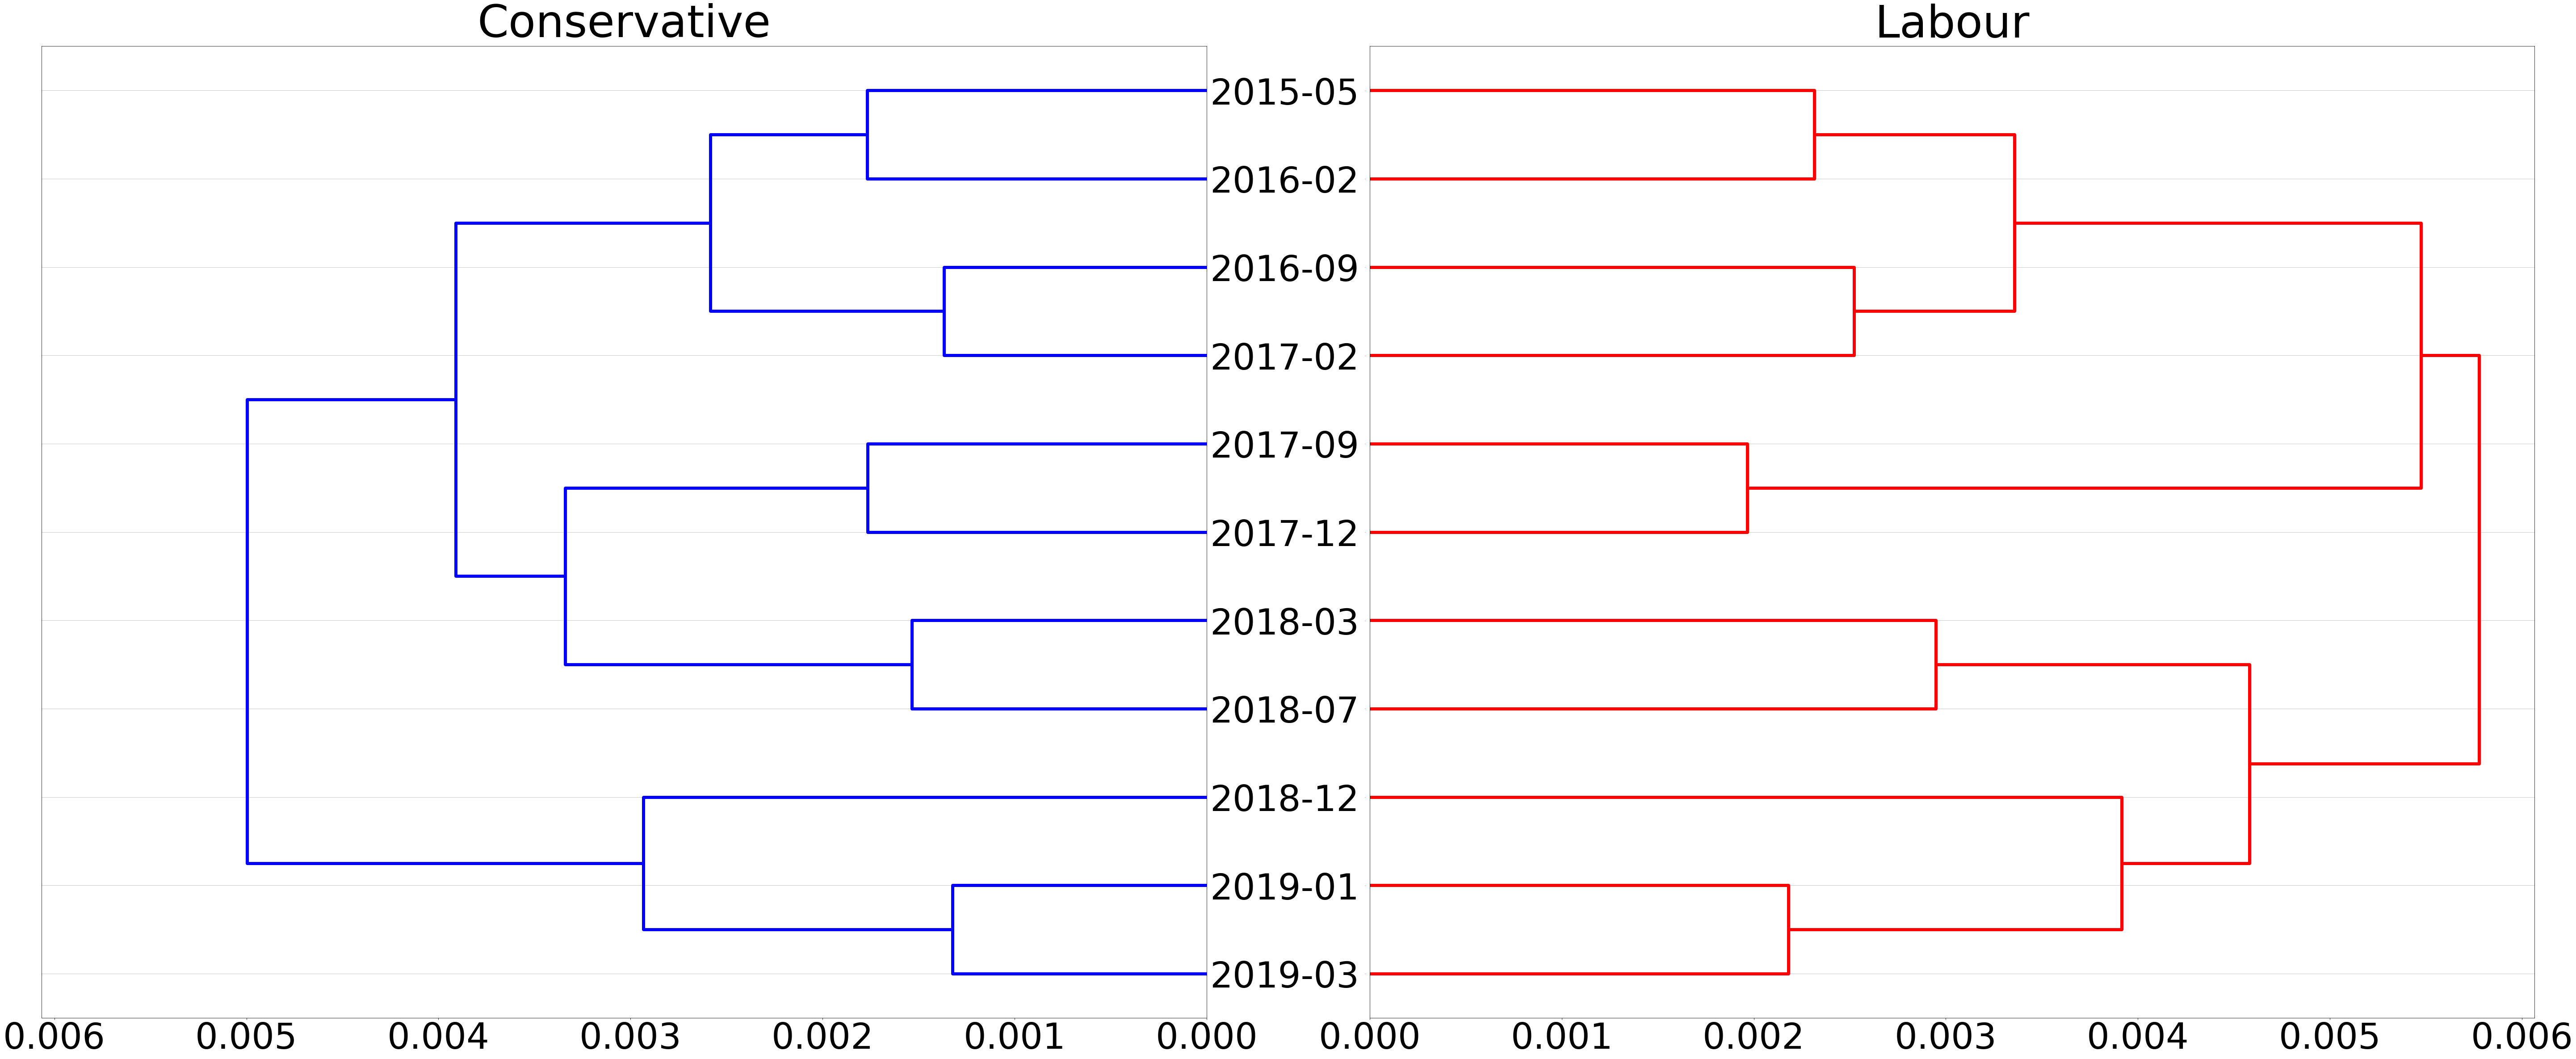

In [74]:
%%time
vnc1, vnc2, g_feats = create_vnc(eu_mentions, all_toks,
                                 gnames=["Conservative", "Labour"], g1=con, g2=lab, 
                                 win_size=5000, win_step=5000, n_toks=1000)

fig = vnc_comparison(["Conservative", "Labour"], vnc1, vnc2, ["Blue", "Red"])
fig.savefig(os.path.join(out_dir, "eu_vnc_party_5k_5k_1k.pdf"))

In [75]:
coph_coeff(vnc1, g_feats["Conservative"])

0.7544304215353775

In [76]:
%%time
clust_kw = get_cluster_keywords(vnc1, vnc2, 0.004, 
                                eu_mentions, all_toks,
                                gnames=["Conservative", "Labour"], g1=con, g2=lab,
                                win_size=5000, win_step=5000, n_toks=1000, w_list=None)

print_t20_kw_per_cluster(clust_kw, ["Conservative", "Labour"])

--------------------------------------
Conservative
--------------------------------------
Cluster number 1
refugees,clause,budget,nuclear,tax,queen,principles,reform,data,research,fishing,welfare,children,air,cut,europe,migration,energy,membership,lords

Cluster number 2
no-,extension,backstop,declaration,withdrawal,tonight,table,alternative,option,votes,motion,meaningful,october,march,voted,agreement,statutory,event,house,avoid

--------------------------------------
Labour
--------------------------------------
Cluster number 1
queen,universities,refugees,steel,skills,nationals,students,campaign,tax,britain,university,energy,europe,education,travel,elected,success,city,women

Cluster number 2
clause,data,principles,powers,devolved,law,transition,fundamental,protection,implementation,ministers,exit,amendments,protections,regulatory,bill,nuclear,exiting,environmental,laws

Cluster number 3
fishing,customs,border,advice,arrangement,lords,white,goods,irish,paper,cabinet,ireland

Cluster

Wall time: 16.6 s


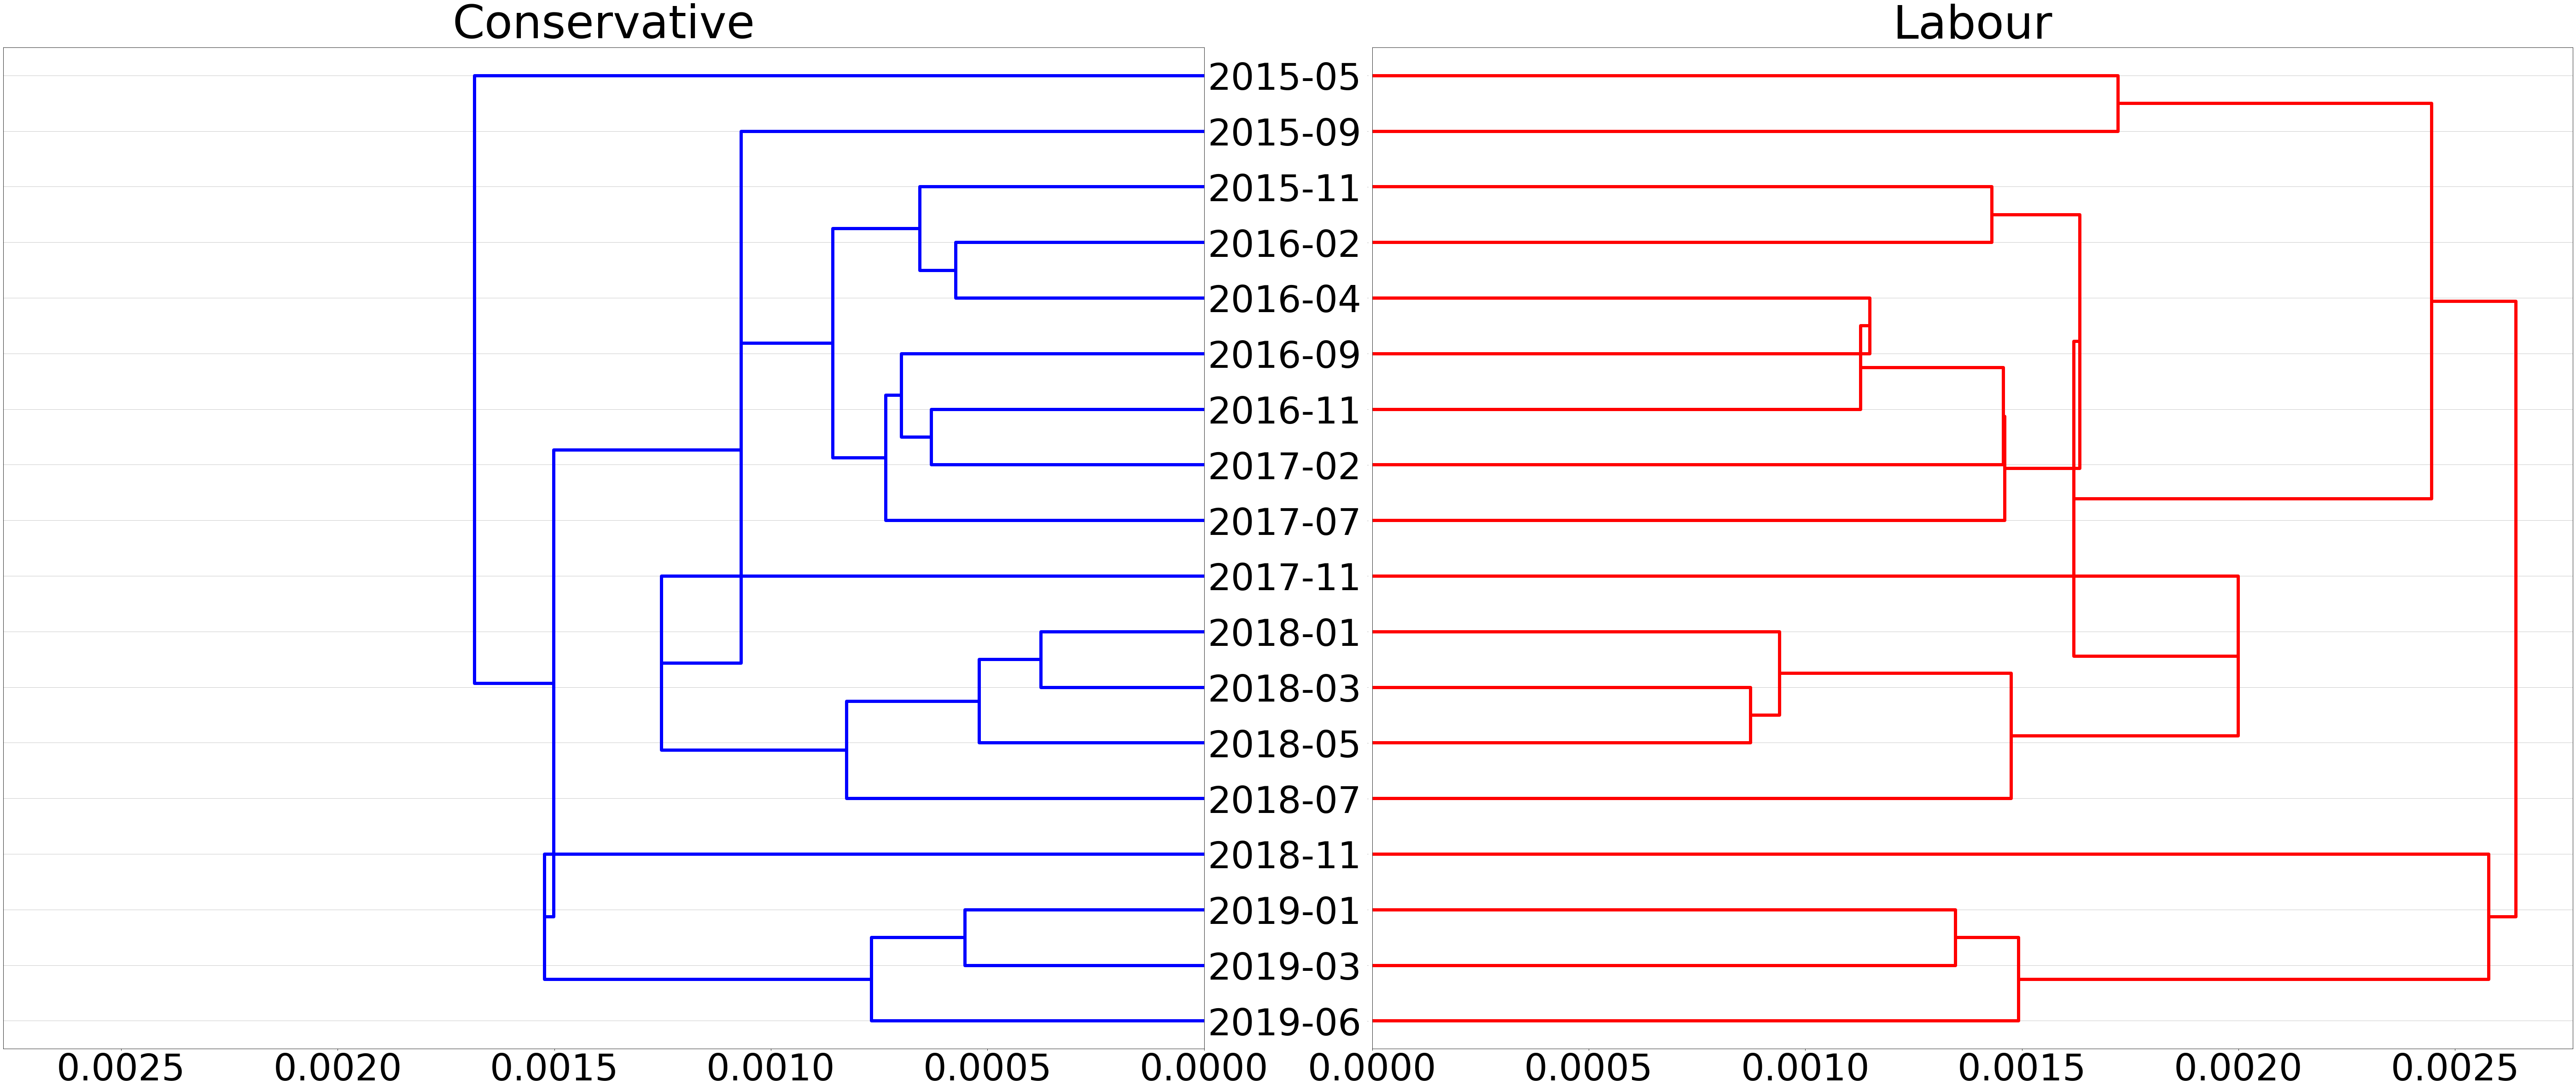

In [77]:
%%time
vnc1, vnc2, g_feats = create_vnc(all_contributions, all_toks,
                                 gnames=["Conservative", "Labour"], g1=con, g2=lab, 
                                 win_size=15000, win_step=15000, n_toks=1000)

fig = vnc_comparison(["Conservative", "Labour"], vnc1, vnc2, ["Blue", "Red"])
fig.savefig(os.path.join(out_dir, "all_vnc_party_15k_15k_1k.pdf"))

Wall time: 28.4 s


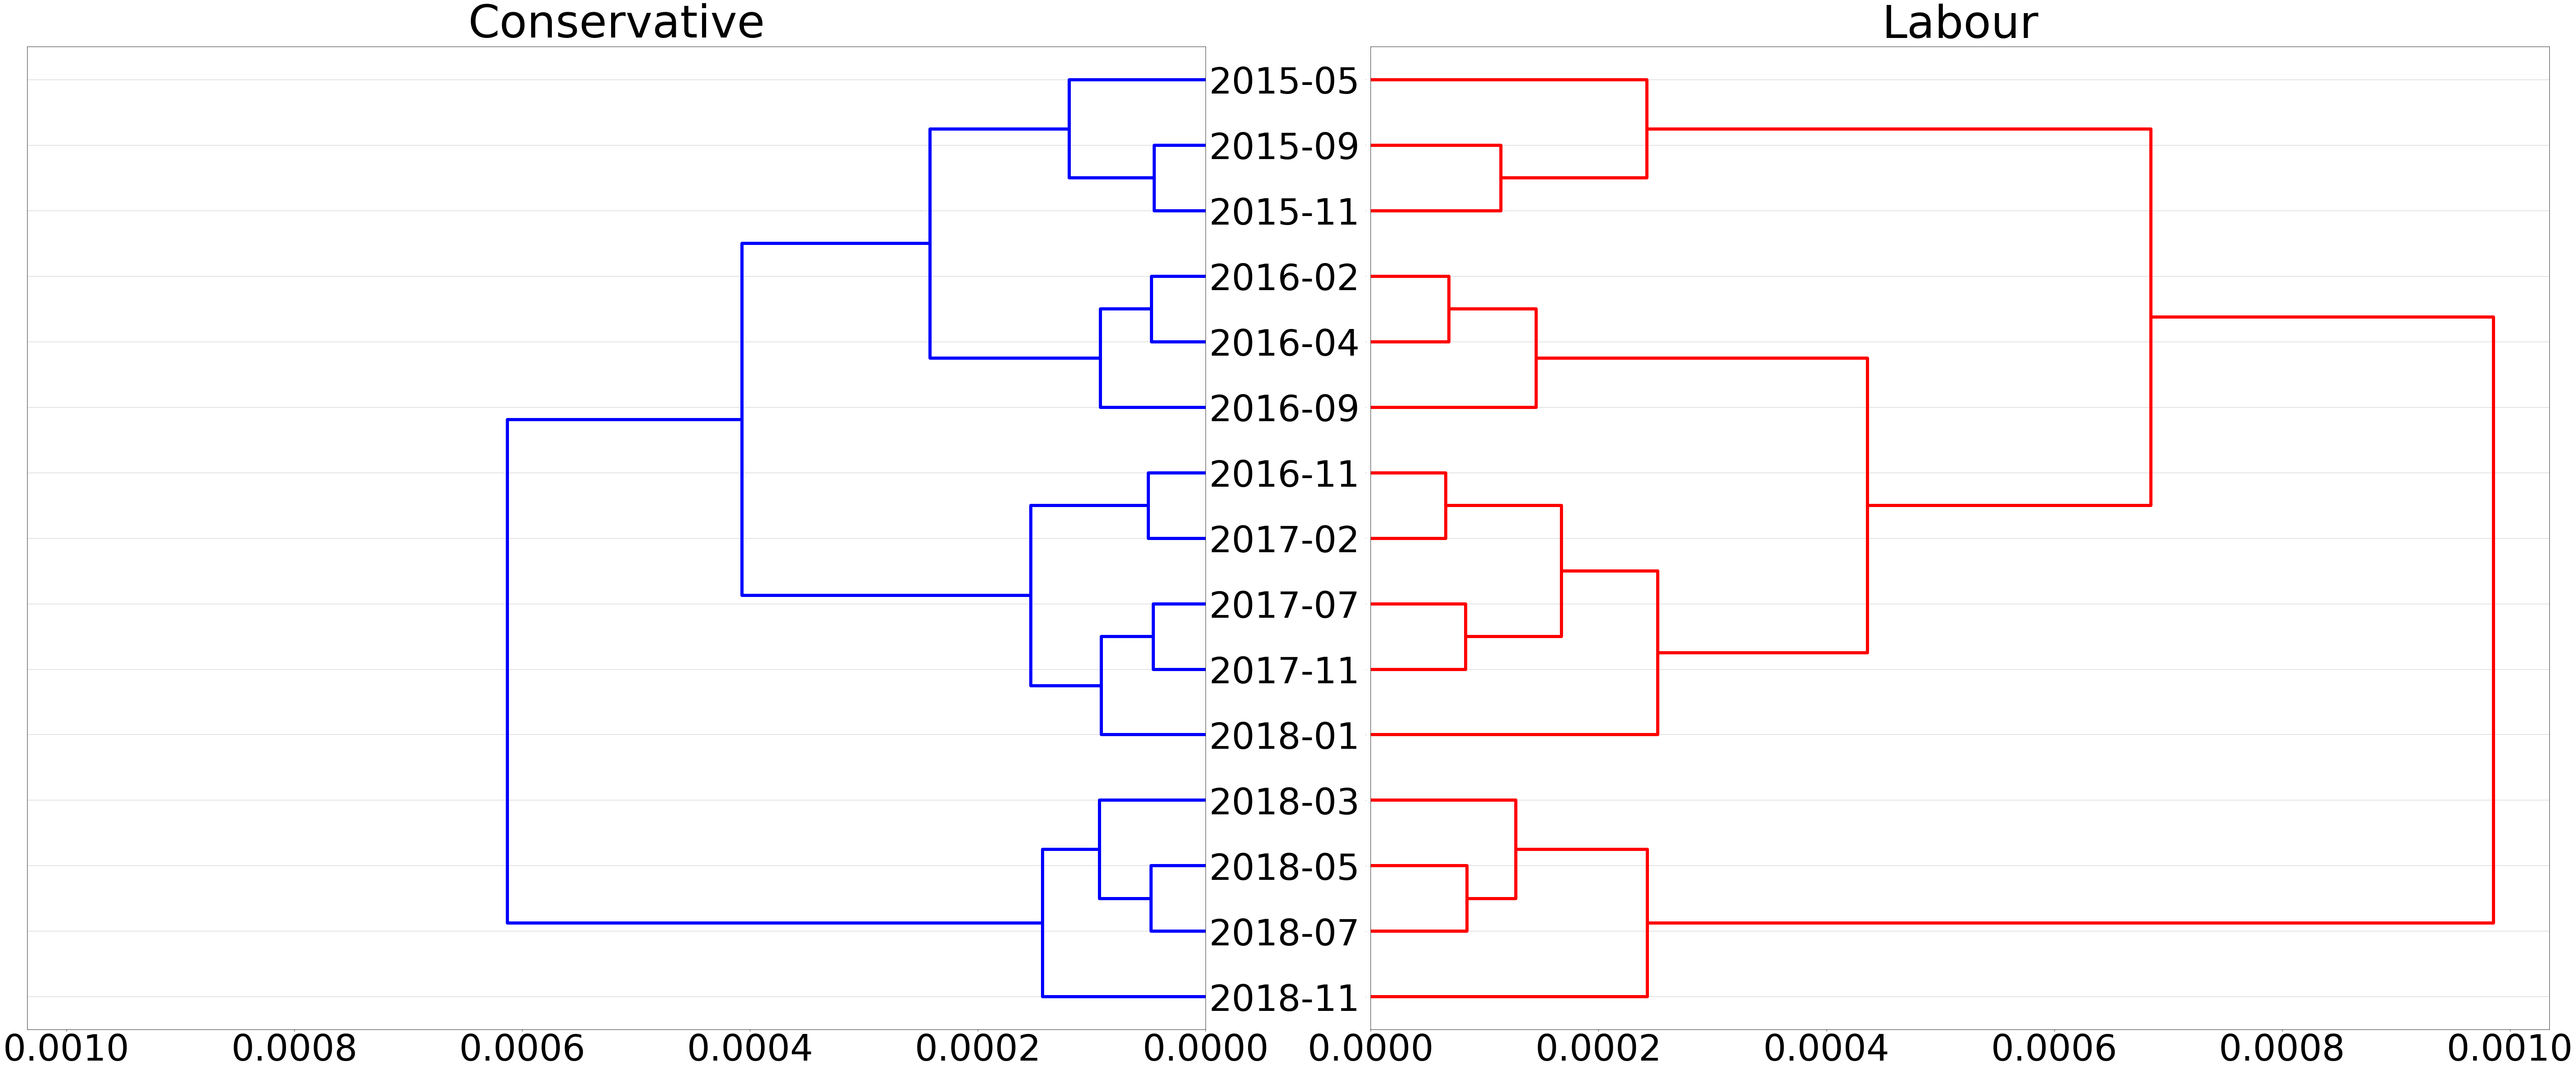

In [89]:
%%time
vnc1, vnc2, g_feats = create_vnc(all_contributions, all_toks,
                                 gnames=["Conservative", "Labour"], g1=con, g2=lab, 
                                 win_size=60000, win_step=15000, n_toks=1000)

fig = vnc_comparison(["Conservative", "Labour"], vnc1, vnc2, ["Blue", "Red"])
fig.savefig(os.path.join(out_dir, "all_vnc_party_60k_15k_1k.pdf"))

In [103]:
%%time
clust_kw = get_cluster_keywords(vnc1, vnc2, 0.0003,
                                all_contributions, all_toks,
                                gnames=["Conservative", "Labour"], g1=con, g2=lab,
                                win_size=60000, win_step=15000, n_toks=1000, w_list=None)

print_t20_kw_per_cluster(clust_kw, ["Conservative", "Labour"])

--------------------------------------
Conservative
--------------------------------------
Cluster number 1
bbc,syria

Cluster number 2


Cluster number 3
withdrawal,brexit,agreement,voted,vote,march

--------------------------------------
Labour
--------------------------------------
Cluster number 1
devolution,wage,bbc,syria,snp,chancellor,tax,scottish

Cluster number 2
bbc

Cluster number 3
customs

Cluster number 4
withdrawal,agreement

Wall time: 28.2 s


In [104]:
print_top_lr_per_cluster(clust_kw, ["Conservative", "Labour"])

--------------------------------------
Conservative
--------------------------------------
Cluster number 1
bbc,syria,reform,welsh,assembly,devolution,wage,wales,planning,welfare

Cluster number 2
customs,debt,universal,fire,devolved,negotiations,credit,industrial,domestic,law

Cluster number 3
withdrawal,brexit,agreement,voted,vote,march,referendum,customs,motion,ireland

--------------------------------------
Labour
--------------------------------------
Cluster number 1
devolution,wage,bbc,syria,snp,chancellor,tax,scottish,proposals,skills

Cluster number 2
bbc,students,education,welsh,prison,schools,success,skills,university,nhs

Cluster number 3
customs,border,armed,defence,data,universal,regulations,rail,law,period

Cluster number 4
withdrawal,agreement,brexit,climate,vote,food,immigration,voted,prime,crime



In [98]:
clust_kw["Conservative"][1].iloc[:10]

,count,comp_count,log-ratio,len,comp_len
word,,,,,
bbc,7061.0,2716.0,1.848257,18990399.0,26304354.0
syria,7174.0,4126.0,1.267991,18990399.0,26304354.0
reform,6927.0,5105.0,0.910314,18990399.0,26304354.0
welsh,6320.0,4682.0,0.902791,18990399.0,26304354.0
assembly,3910.0,2914.0,0.894136,18990399.0,26304354.0
devolution,4651.0,3517.0,0.873177,18990399.0,26304354.0
wage,3848.0,3172.0,0.748707,18990399.0,26304354.0
wales,10930.0,9338.0,0.697128,18990399.0,26304354.0
planning,9152.0,7833.0,0.694540,18990399.0,26304354.0


In [96]:
clust_kw["Conservative"][2].iloc[:10]

,count,comp_count,log-ratio,len,comp_len
word,,,,,
customs,5673.0,6186.0,0.939506,14652401.0,30642352.0
debt,3376.0,4153.0,0.765591,14652401.0,30642352.0
universal,5726.0,7304.0,0.713258,14652401.0,30642352.0
fire,3365.0,4776.0,0.559257,14652401.0,30642352.0
devolved,5024.0,7317.0,0.522019,14652401.0,30642352.0
negotiations,7255.0,10672.0,0.507639,14652401.0,30642352.0
credit,6455.0,9532.0,0.502064,14652401.0,30642352.0
industrial,4200.0,6304.0,0.478569,14652401.0,30642352.0
domestic,4301.0,6461.0,0.477361,14652401.0,30642352.0


In [97]:
clust_kw["Conservative"][3].iloc[:10]

,count,comp_count,log-ratio,len,comp_len
word,,,,,
withdrawal,9155.0,4778.0,2.467807,11651953.0,33642800.0
brexit,12115.0,13008.0,1.427125,11651953.0,33642800.0
agreement,16813.0,21111.0,1.201317,11651953.0,33642800.0
voted,7110.0,9057.0,1.180564,11651953.0,33642800.0
vote,13164.0,17763.0,1.097463,11651953.0,33642800.0
march,4466.0,6306.0,1.032031,11651953.0,33642800.0
referendum,9347.0,14699.0,0.876611,11651953.0,33642800.0
customs,4609.0,7250.0,0.876256,11651953.0,33642800.0
motion,5763.0,9600.0,0.793562,11651953.0,33642800.0


## Now - Keywords

In [80]:
from features import get_ngram_lr_and_ll

In [81]:
%%time
# Get key words for EU debate
kw = get_ngram_lr_and_ll(all_toks.loc[eu_mentions.index], all_toks.loc[non_eu_mentions.index], 1)

Wall time: 24 s


In [82]:
kw_list = list(kw[kw["LR"] > 1].index)
kw_list = [k for k in kw_list if all_counts[k] > 100]

Wall time: 12 s


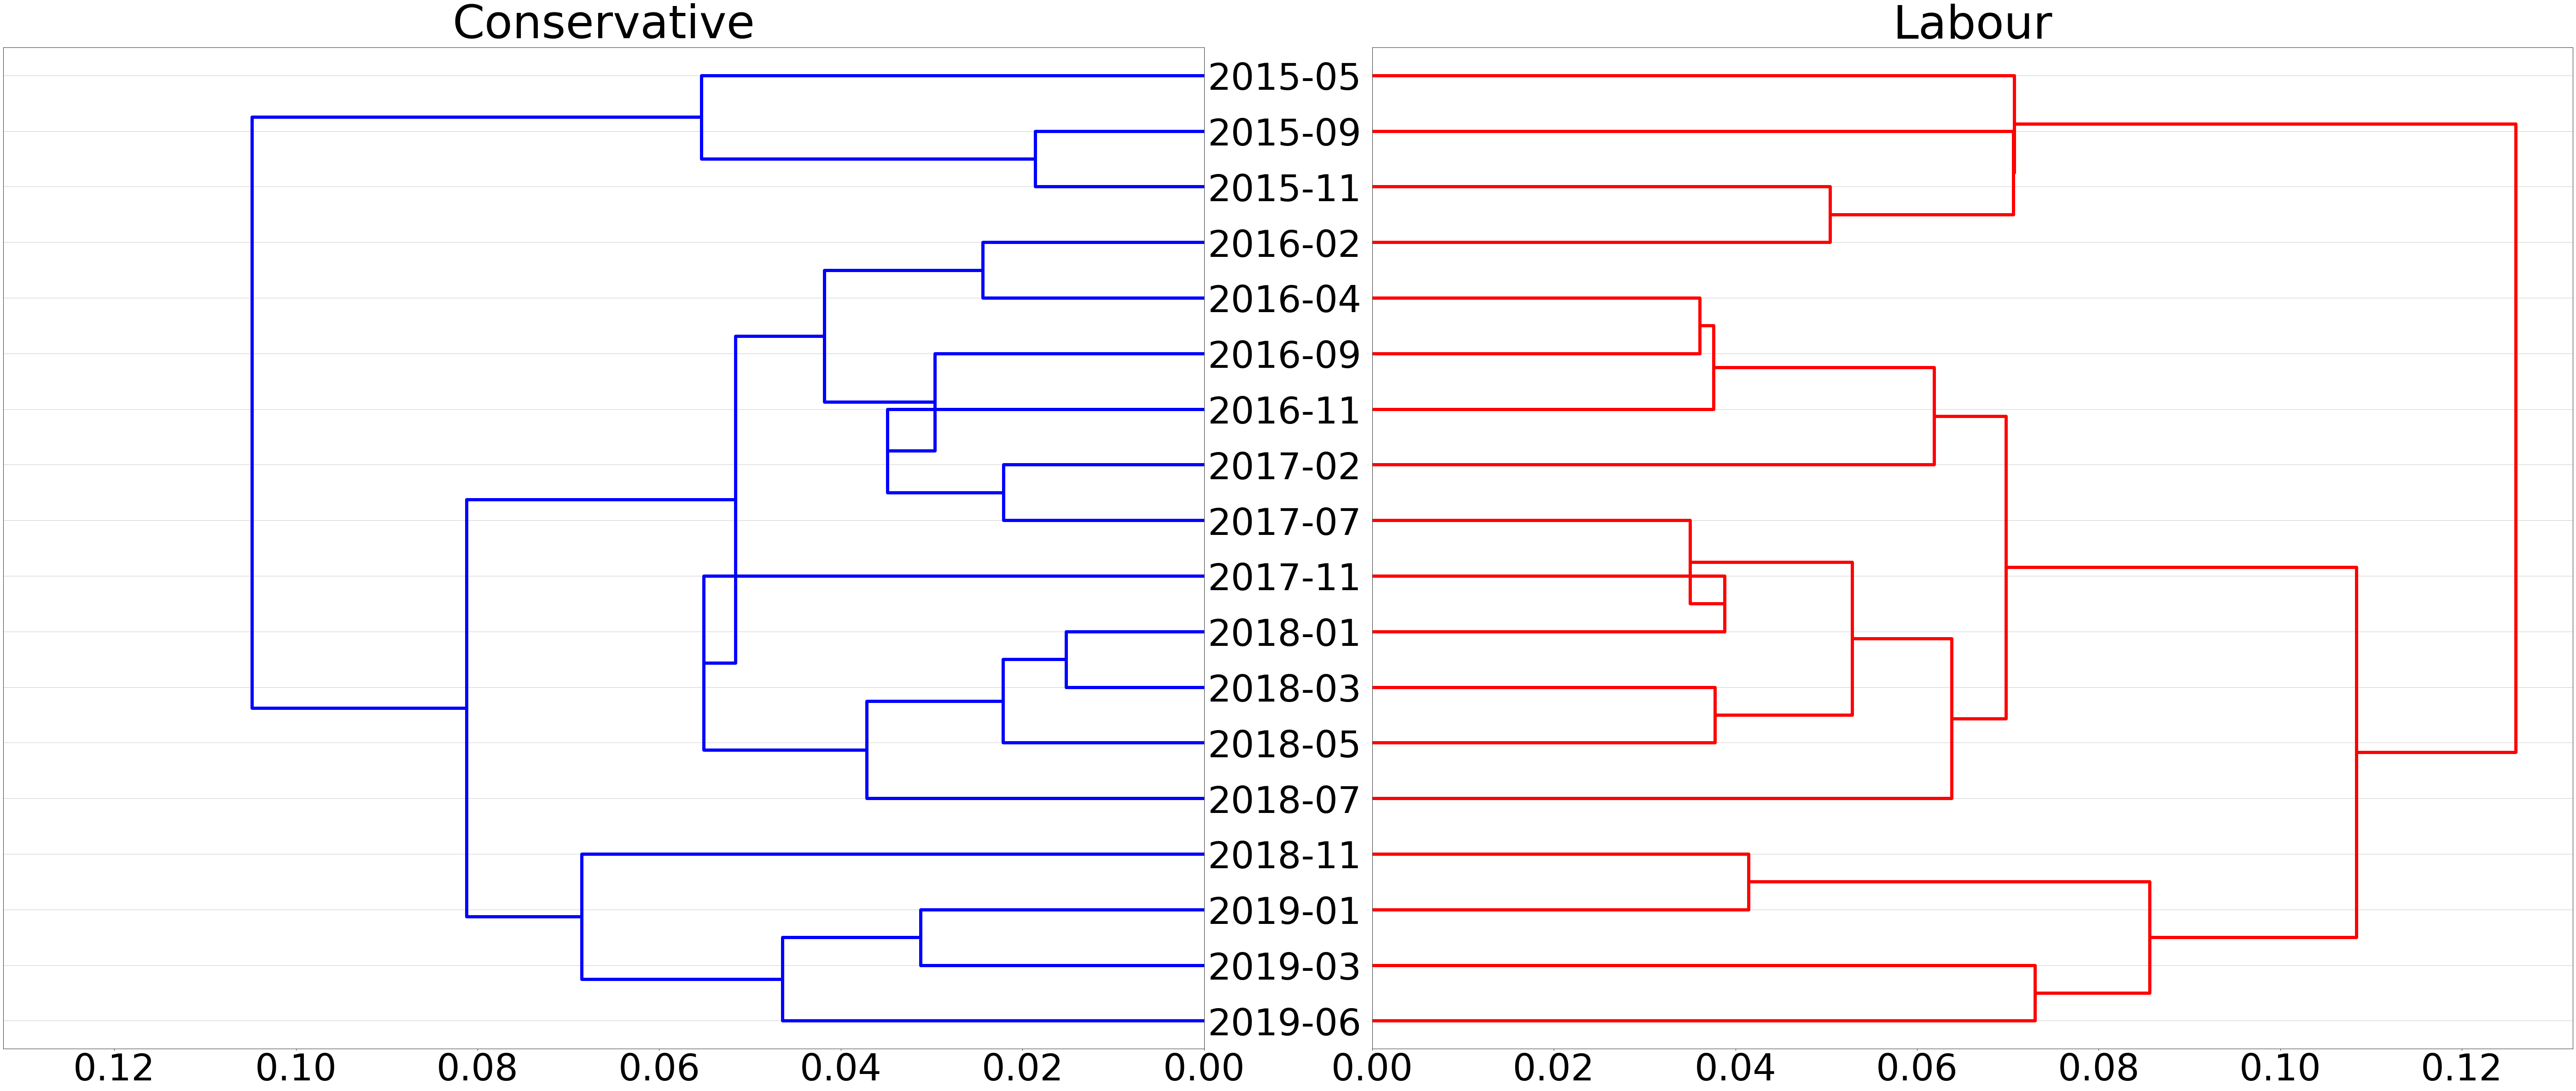

In [83]:
%%time
vnc1, vnc2, g_feats = create_vnc(all_contributions, all_toks,
                                 gnames=["Conservative", "Labour"], g1=con, g2=lab, 
                                 win_size=15000, win_step=15000, n_toks=None, w_list=kw_list)

fig = vnc_comparison(["Conservative", "Labour"], vnc1, vnc2, ["Blue", "Red"])
fig.savefig(os.path.join(out_dir, "all_vnc_party_15k_15k_kw.pdf"))

Wall time: 23.6 s


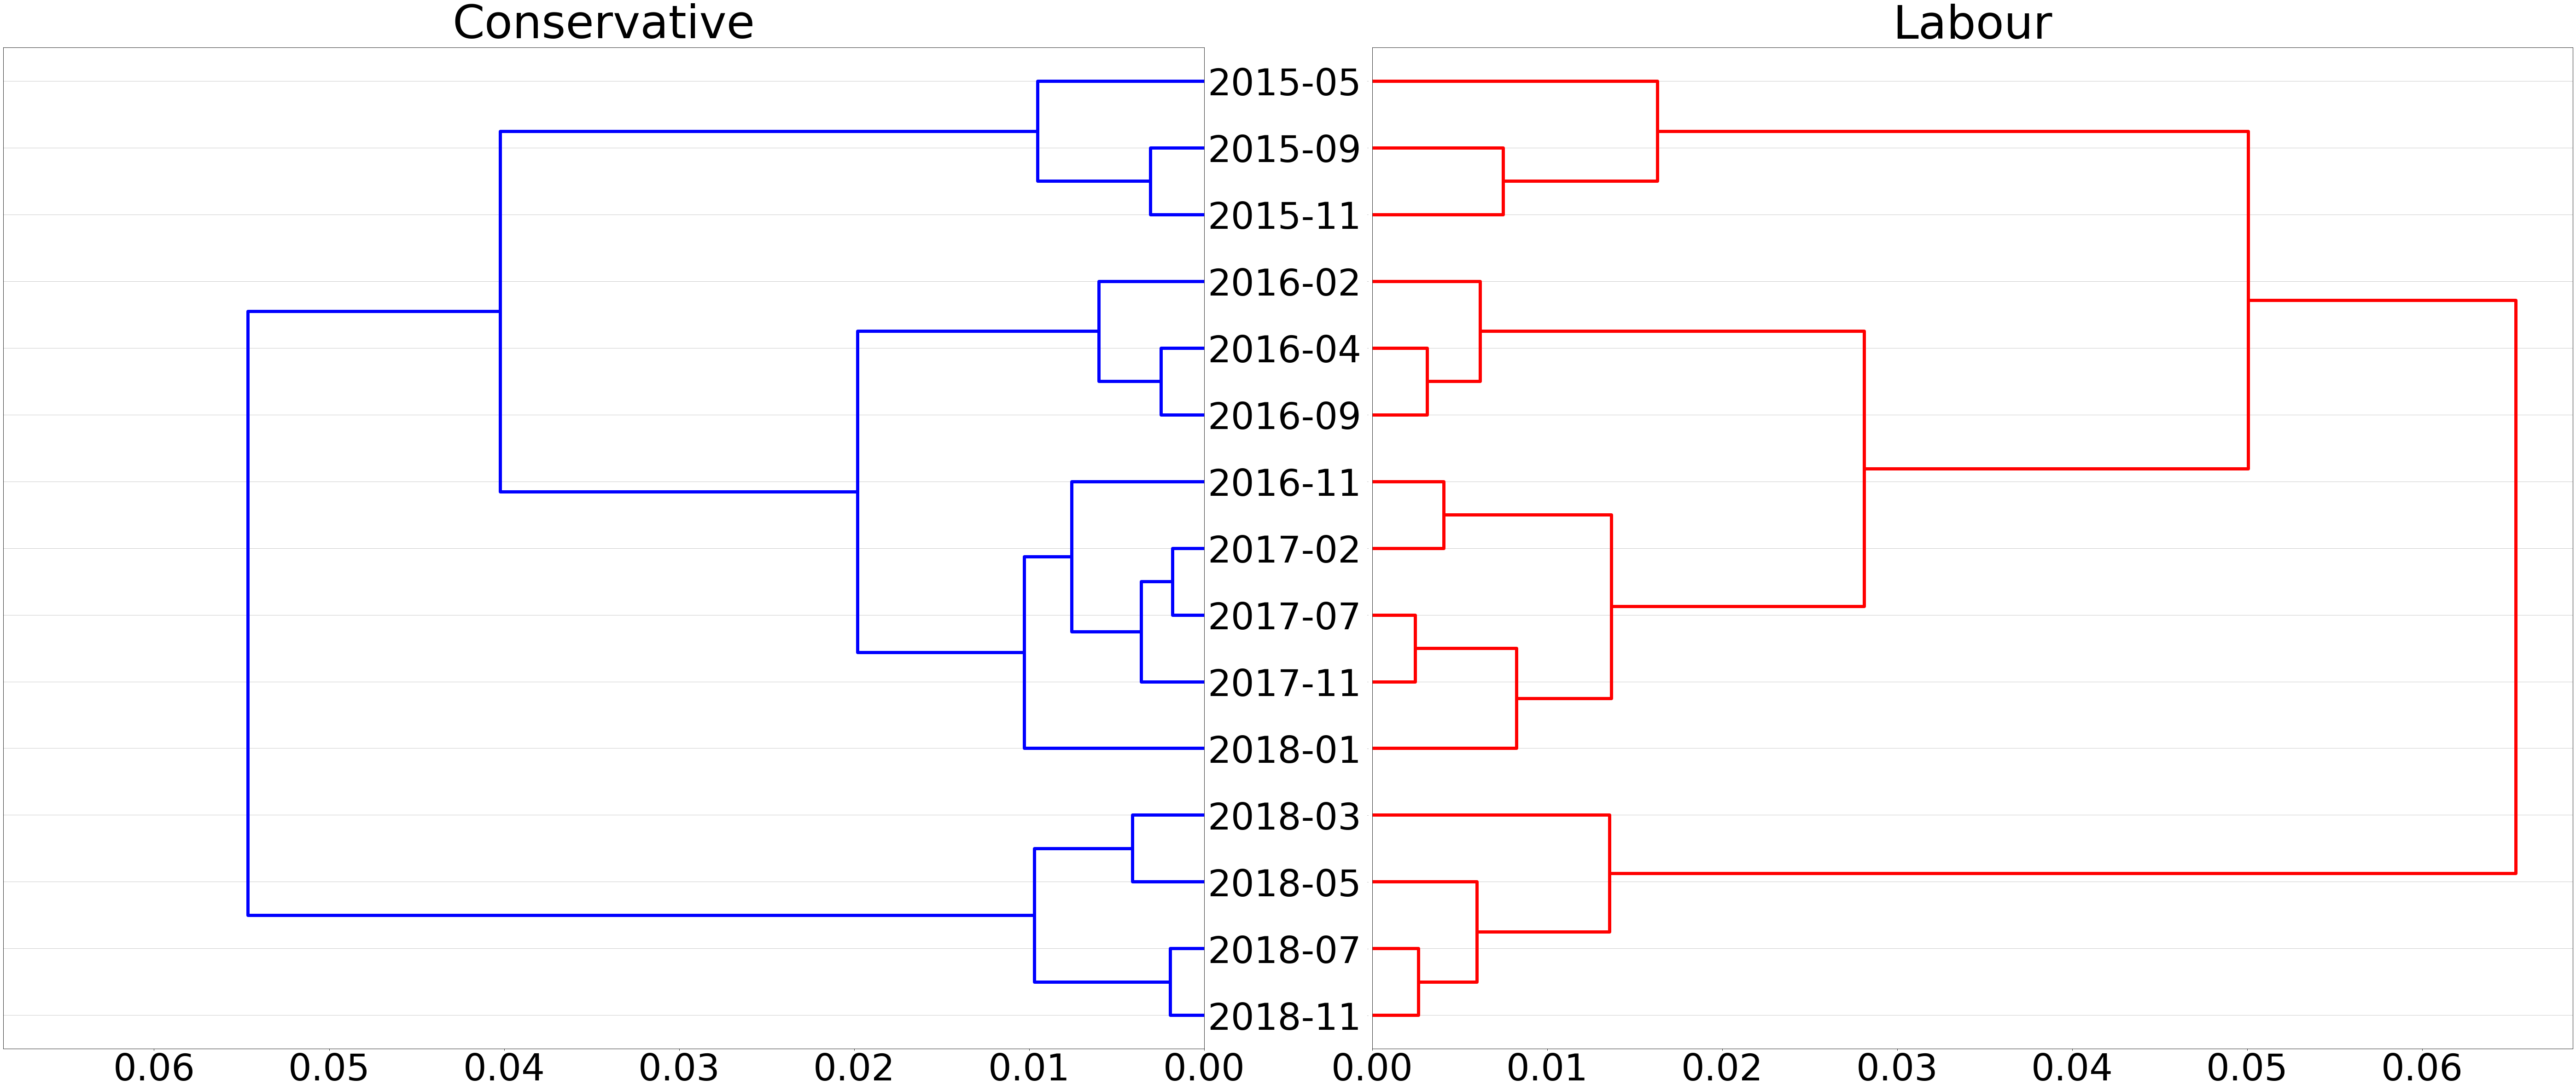

In [84]:
%%time
vnc1, vnc2, g_feats = create_vnc(all_contributions, all_toks,
                                 gnames=["Conservative", "Labour"], g1=con, g2=lab, 
                                 win_size=60000, win_step=15000, n_toks=None, w_list=kw_list)

fig = vnc_comparison(["Conservative", "Labour"], vnc1, vnc2, ["Blue", "Red"])
fig.savefig(os.path.join(out_dir, "all_vnc_party_60k_15k_kw.pdf"))

In [85]:
%%time
clust_kw = get_cluster_keywords(vnc1, vnc2, 0.03, 
                                all_contributions, all_toks,
                                gnames=["Conservative", "Labour"], g1=con, g2=lab,
                                win_size=60000, win_step=15000, n_toks=None, w_list=kw_list)

print_t20_kw_per_cluster(clust_kw, ["Conservative", "Labour"])

--------------------------------------
Conservative
--------------------------------------
Cluster number 1
prüm,eritrea,renegotiation,eurozone,schengen,greek,ttip,irreversible,purdah,deport,smugglers,rebate,tape,migrants,mediterranean,imf,euro,relocation,greece,dumping

Cluster number 2
atol,euratom,florence,onr,serbia,anguilla,sectoral,jmc,gdpr,catalonia,enactment,frameworks,sifting,viii,deficient,supremacy,automation,triggering,en,absurdity

Cluster number 3
seaborne,maduro,backstop,revoke,amendable,no-,organic,si,honda,revocation,revoking,ferries,prorogation,declaration,just-,attorney,chequers,brady,withdrawal,sis

--------------------------------------
Labour
--------------------------------------
Cluster number 1
ttip,bass,greek,unionists,renegotiation,neath,dumping,greece,turnout,mediterranean,ruislip,relocation,uxbridge,inward

Cluster number 2
onr,atol,euratom,anguilla,gdpr,florence,precautionary,jmc,sectoral,albania,efta,tariff-,scotch,whisky,sifting,divergence,retained,seas

In [86]:
# from word_clouds import draw_wordcloud
# for clust_num, curr_kw in clust_kw["Conservative"].items():
#     print("Cluster number {}".format(clust_num))
#     kw_to_print = curr_kw[curr_kw["log-ratio"]>1]["log-ratio"]
#     kw_to_print = kw_to_print[kw_to_print.index.to_series().apply(lambda x: all_counts[x] > 100)]
#     draw_wordcloud(kw_to_print.apply(abs))
#     plt.show()

Wall time: 4.45 s


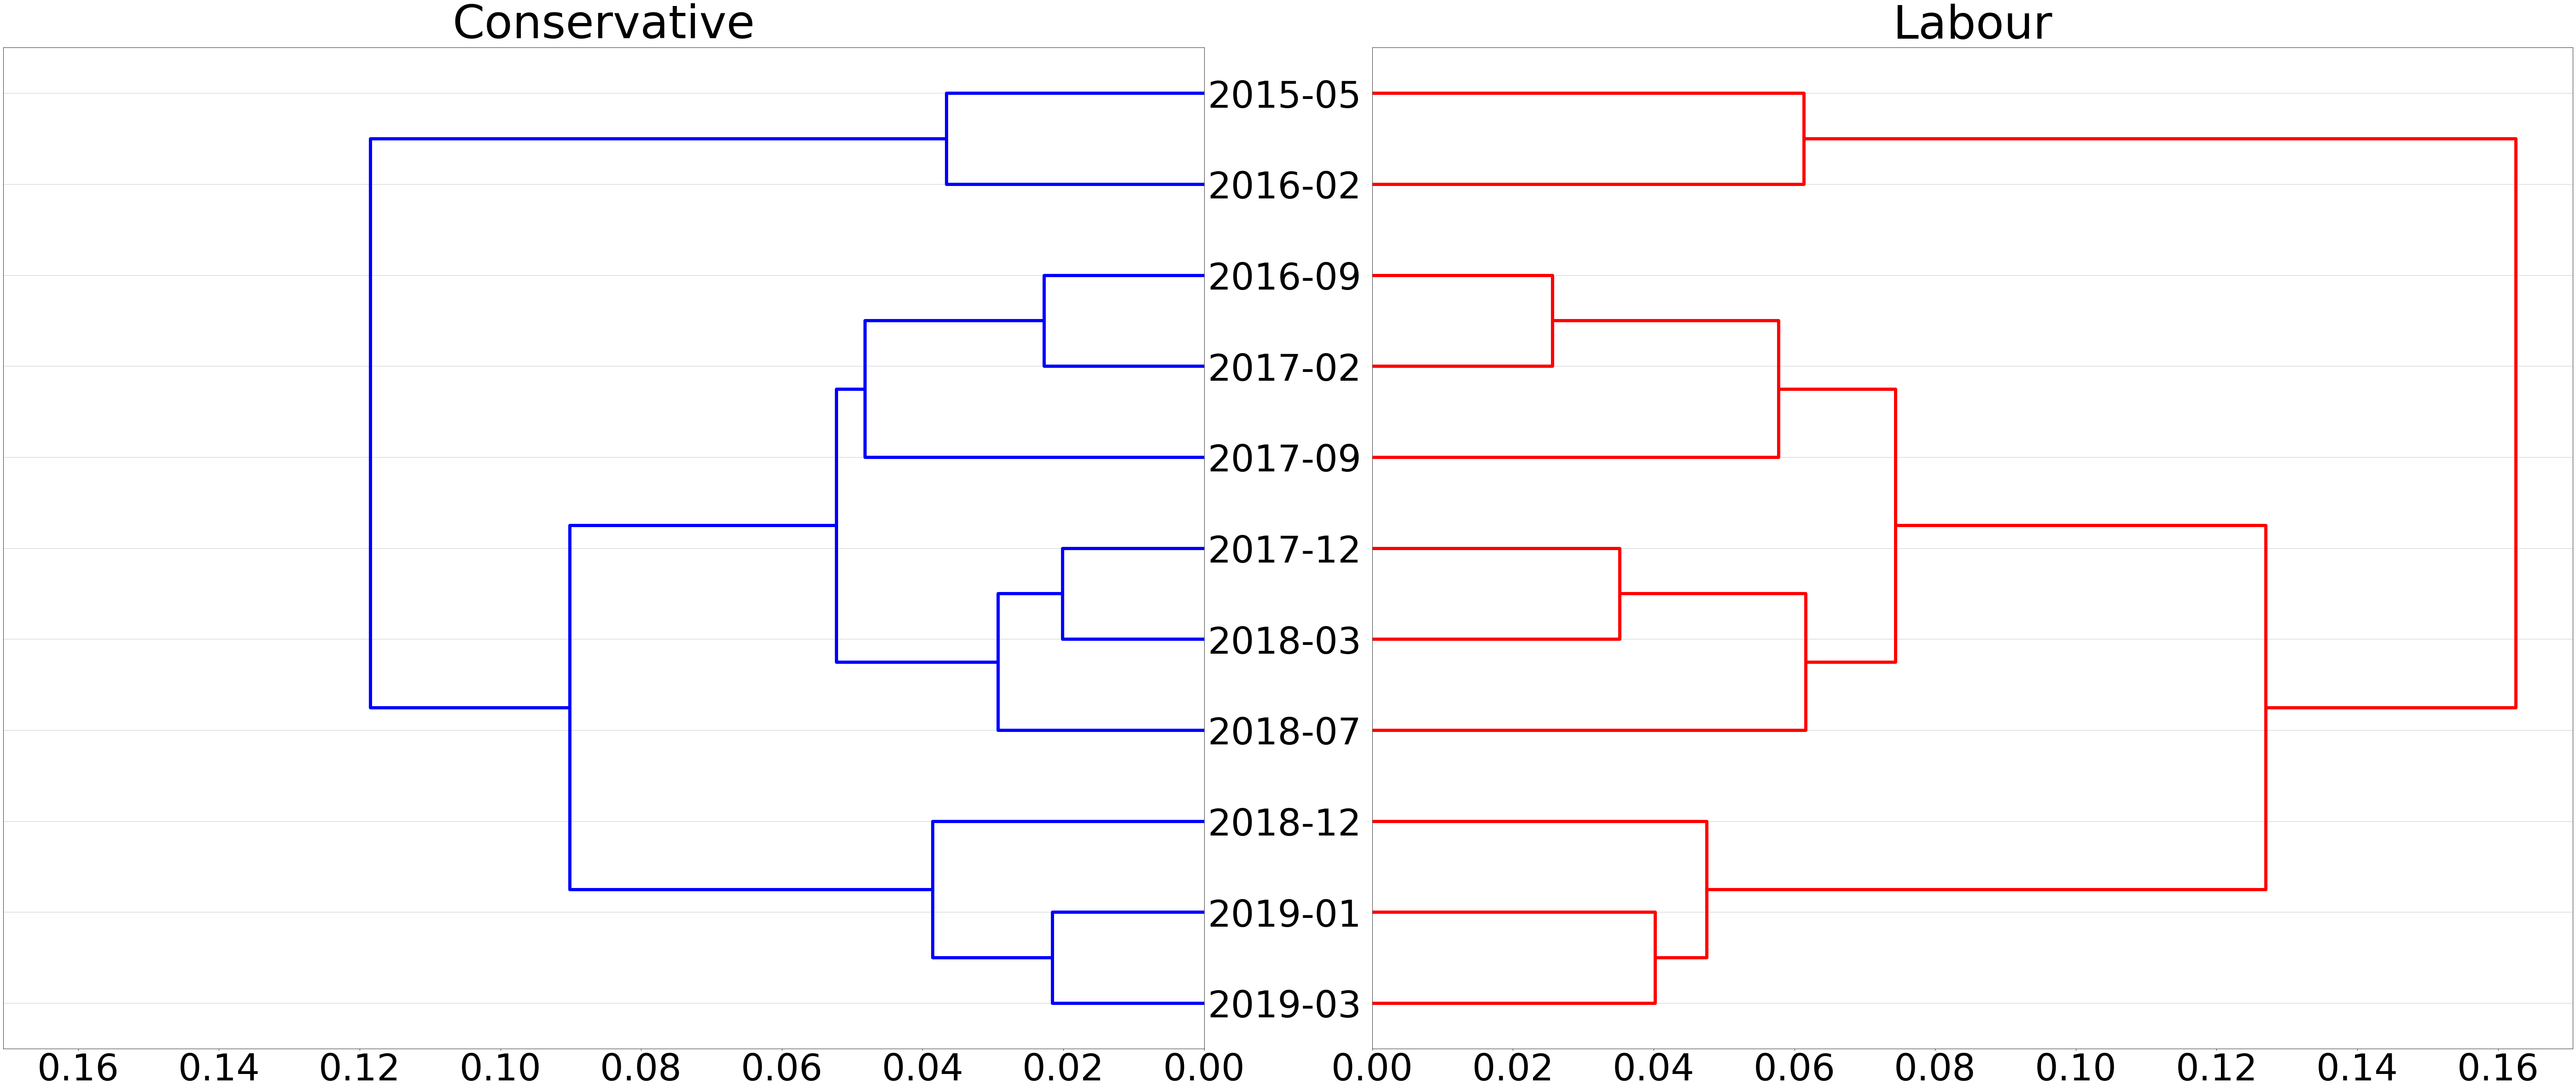

In [87]:
%%time
vnc1, vnc2, g_feats = create_vnc(eu_mentions, all_toks,
                                 gnames=["Conservative", "Labour"], g1=con, g2=lab, 
                                 win_size=5000, win_step=5000, n_toks=None, w_list=kw_list)

fig = vnc_comparison(["Conservative", "Labour"], vnc1, vnc2, ["Blue", "Red"])
fig.savefig(os.path.join(out_dir, "eu_vnc_party_5k_5k_kw.pdf"))

In [88]:
%%time
clust_kw = get_cluster_keywords(vnc1, vnc2, 0.03, 
                                eu_mentions, all_toks,
                                gnames=["Conservative", "Labour"], g1=con, g2=lab,
                                win_size=5000, win_step=5000, n_toks=None, w_list=kw_list)

print_t20_kw_per_cluster(clust_kw, ["Conservative", "Labour"])

--------------------------------------
Conservative
--------------------------------------
Cluster number 1
purdah,eurozone,greek,renegotiation,schengen,greece,euro,currency,migrants,referendums,elections,turkey,europe,sovereignty,germany,britain,migration

Cluster number 2
turkey,migrants,migration,june,membership,germany,nationals,remaining,industries,europe,france

Cluster number 3
triggering,repeal,trigger,nationals,exiting,post-

Cluster number 4
charter,retained,euratom,principles,eea,rights,transition,laws,exit,learned,certainty

Cluster number 5
chequers,frictionless,frameworks,waters,fishermen,fisheries,beaconsfield,customs,chains,implementation,fish,white,continuity,internal,text,fishing,gibraltar,uk-,goods,regulatory

Cluster number 6
si,extension,revoke,instrument,no-,medicines,approve,rejected,votes,declaration,compromise,motion,elections,orderly,withdrawal,instruments,scenario,preparations,meaningful,table

Cluster number 7
backstop,attorney,compromise,declaration,negotia

# Addendum: Comparison VNC for ACE